# QAOA and QAA to solve a QUBO problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

## 1. Introduction 

In this tutorial, we illustrate how to solve a Quadratic Unconstrained Binary Optimization (QUBO) instance using an ensemble of Rydberg atoms in analog mode.

QUBO has been extensively studied [Glover, et al., 2018](https://arxiv.org/pdf/1811.11538.pdf) and is used to model and solve numerous categories of optimization problems including important instances of network flows, scheduling, max-cut, max-clique, vertex cover and other graph and management science problems, integrating them into a unified modeling framework.

Mathematically, a QUBO instance consists of a symmetric matrix $Q$ of size $(N \times N)$, and the optimization problem associated with it is to find the bitstring $z=(z_1, \dots, z_N) \in \{0, 1 \}^N$ that minimizes the quantity
$$f(z) = z^{T}Qz$$ 

Suppose we are given the following QUBO matrix $Q$:

In [2]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

In this tutorial, we will demonstrate how this QUBO instance can be mapped and solved using neutral atoms. For reasons that will become apparent further along, this QUBO instance is particularly amenable to embedding on a neutral-atom device since:

1. All the off-diagonal terms are positive.
2. The diagonal terms are all equal.

Furthermore, because the QUBO is small, we can classically check all solutions and mark the optimal ones. This will help us later in the tutorial to visualize the quality of our quantum approach.

In [3]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('01011', -27.288260020000003), ('00111', -27.288260019999996), ('00101', -19.64648408)]


This QUBO admits `01011` and `00111` as optimal solutions.

### Embedding a QUBO onto an atomic register

We now illustrate how to use Pulser to embbed the QUBO matrix $Q$ on a neutral-atom device.

The key idea is to encode the off-diagonal terms of $Q$ by using the Rydberg interaction between atoms. Recalling that the interaction between two atoms is given by 
$$
U_{ij}=C_6/r_{ij}^6,
$$
we note that 

1. The term is strictly positive, which is why it matters that our off-diagonal terms are too.
2. Its magnitude depends on the pairwise distance between atoms $i$ and $j$, $r_{ij}$. 

As such, we attempt a simple minimization procedure to find the optimal positions of the atoms in the Register that replicate best the off-diagonal terms of $Q$:

In [4]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [5]:
costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

We can then plot the obtained coordinates in a Register using:

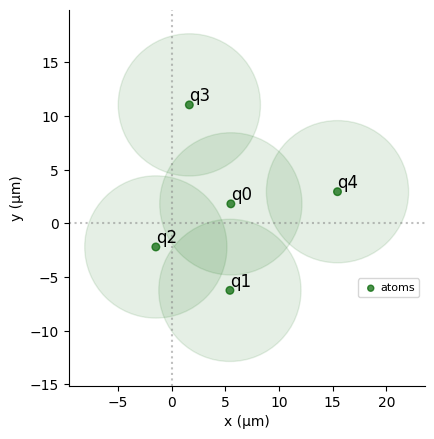

In [6]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In this case, this simple procedure was enough to give a good and valid embedding but it will not always be so. For QUBO instances that are not as easy to embbed as this one, more complex embedding strategies are required.

## 2. Building the quantum algorithm 

Now that the QUBO $Q$ is encoded in the Register, we can peprare the following Ising Hamiltonian $H_Q$:

$$ H_Q= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2} \sigma_i^z+\sum_{j \lt i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j. $$

In the case where our mapping of the atoms is perfect, the last sum replicates exactly the off-diagonal terms of $Q$. Additionally, since the diagonal terms are all the same, we can use a Rydberg global beam with an approriate detuning $\delta$ (otherwise, some kind of local addressability capabilities would be necessary).

As such, the next step is to prepare the ground-state of $H_Q$ to output the optimal bitstrings. To do so we present two different approaches, namely the Quantum Approximation Optimization Algorithm (QAOA) and the Quantum Adiabatic Algorithm (QAA) that have been introduced to prepare ground-states of Hamiltonians.

### QAOA

This algorithm (see [Farhi, et al., 2014](https://arxiv.org/pdf/1411.4028.pdf)) has gained a lot of traction lately as a gate-based quantum algorithm. It has shown promising results in a number of applications and yields decent results for low-depth circuits.

All atoms are initially in the groundstate $|00\dots0\rangle$ of the `ground-rydberg` basis.  We then apply $p$ layers of alternating non-commutative Hamiltonians. The first one, called the mixing Hamiltonian $H_M$, is realized by taking $\Omega = 1$ rad/µs, and $\delta = 0$ rad/µs in the Hamiltonian equation. The second Hamiltonian $H_Q$ is realized with $\Omega =0$ rad/µs and $\delta = 1.$ rad/µs. $H_M$ and $H_Q$ are applied turn in turn with parameters $\tau$ and $t$ respectively. A classical optimizer is then used to estimate the optimal parameters. 

Instead of creating a new `Sequence` everytime the quantum loop is called, we are going to create a parametrized `Sequence` and give that to the quantum loop.

In [7]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

Once we have the parameters that we want to apply, we use the `.build()` method to assign these values into a `assigned_seq` sequence. It is this sequence which is simulated every time the quantum loop is called.

Experimentally, we don't have access to the state vector $|\psi\rangle$. We therefore make it more realistic by taking samples from the state vector that results from running the simulation with `simul.run()`. This is done with the built-in method `results.sample_final_state()`, in which we add the measurement basis which was declared at the end of the sequence, and the number of samples desired. Currently, the repetition rate of the machine is $5$ Hz.

In [8]:
def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [9]:
np.random.seed(123)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

In [10]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])

We can then plot the distribution of the samples, to see the most frequent bitstrings sampled.

In [11]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

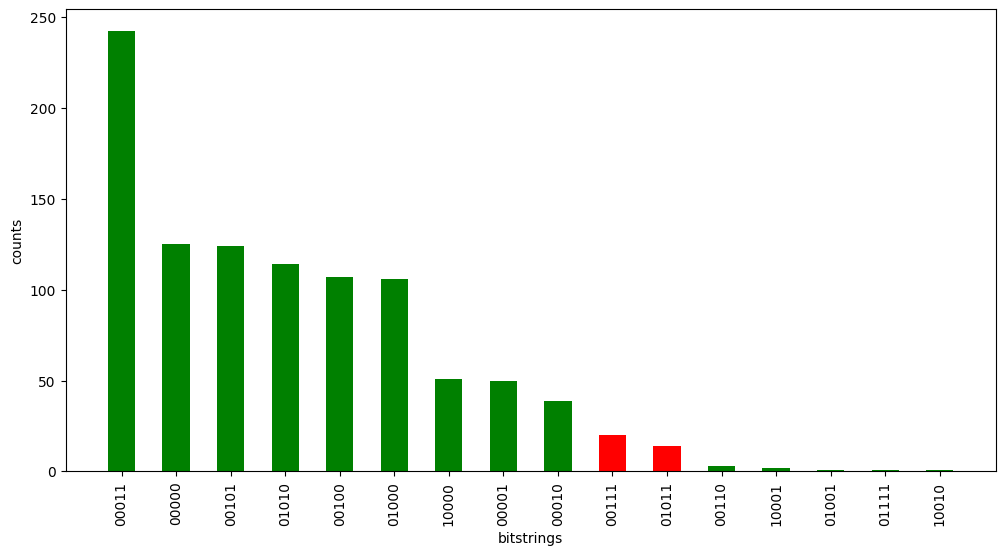

In [12]:
plot_distribution(example_dict)

The bitstrings `01011` and `00111` (in red) correspond to the two optimal solutions (calculated at the beginning of the notebook). The goal of QAOA is to choregraph interferences between the basis states, in order to maximize the frequency of the optimal solution states. 

## 3. Optimization 

We estimate the cost of a sampled state vector by making an average over the samples. This is done by taking the corresponding bitstring ${\bf z}=(z_1, \ldots, z_N)$ and calculating

$$
C({\bf z}) = {\bf z}^\top \cdot Q \cdot {\bf z}
$$

Determining the cost of a given bitstring takes polynomial time. The average estimate is then used in the classical loop to optimize the variational parameters $\tau$ and $t$.

In [13]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

To perform a minimization loop, we define the following function that will be called at each step by SciPy. `*args` enables to pass the QUBO value, and `params` contains the trial value to score, which changes at each step.

In [14]:
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

### QAOA for depth $p = 2$

We now use a classical optimizer `minimize` in order to find the best variational parameters. This function takes as arguments `func`, the QUBO $Q$ and an initial point `x0` for the simplex in Nelder-Mead minimization. As the optimizer might get trapped in local minima, we repeat the optimization 20 times and select the parameters that yield the best approximation ratio.

In [15]:
scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

We can now plot the sample that we woud obtain using the optimal variational parameters.

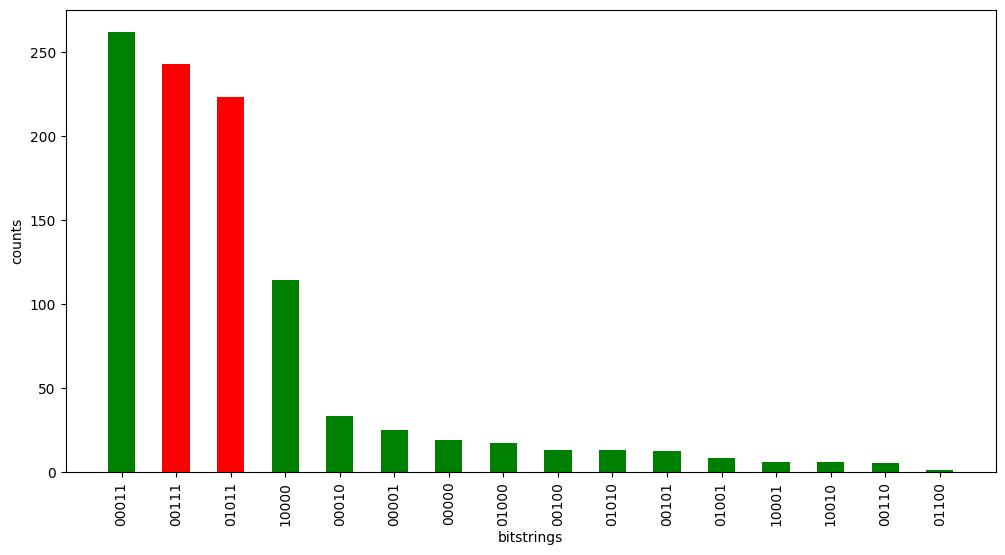

In [16]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)

QAOA is capable of finding good variational parameters $\tau$ and $t$. Now, sampling from this final state $|\psi(t_{f})\rangle$ will return both optimal strings with high probability.

However, using QAOA to solve the problem is not the best idea; it's difficult to yield a >90% quality solution without going to high depths of the QAOA, implying that the growing closed-loop optimization can rapidly become expensive, with no guarantee of convergence. We therefore propose another approach called the Quantum Adiabatic Algorithm (QAA). This fast, reliant and exclusively analog method shows optimal convergence to the solution.

## Quantum Adiabatic Algorithm

The idea behind the adiabatic algorithm (see [Albash, Lidar, 2018](https://arxiv.org/pdf/1611.04471.pdf)) is to slowly evolve the system from an easy-to-prepare groundstate to the groundstate of $H_Q$. If done slowly enough, the system of atoms stays in the instantaneous ground-state.

In our case, we continuously vary the parameters $\Omega(t), \delta(t)$ in time, starting with $\Omega(0)=0, \delta(0)<0$ and ending with $\Omega(0)=0, \delta>0$. The ground-state of $H(0)$ corresponds to the initial state $|00000\rangle$ and the ground-state of $H(t_f)$ corresponds to the ground-state of $H_Q$.

To ensure that we are not exciting the system to states that are too excited, we keep $\Omega \in [0, \Omega_{\text{max}}]$, and choose $\Omega_{\text{max}}$ as the median of the values of Q to ensures that the adiabatic path is efficient.

In [17]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

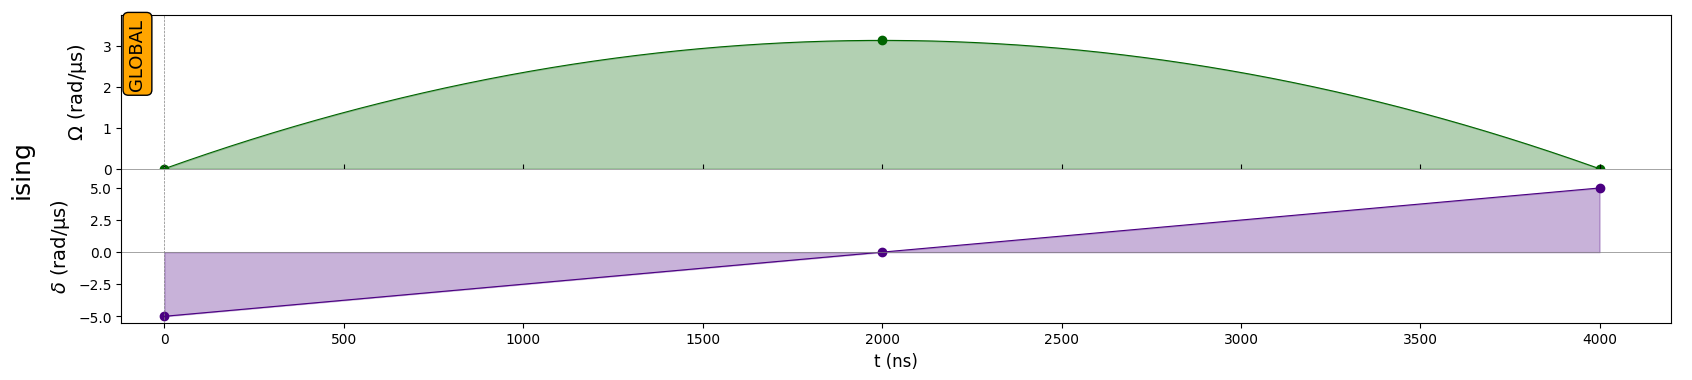

In [18]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [19]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

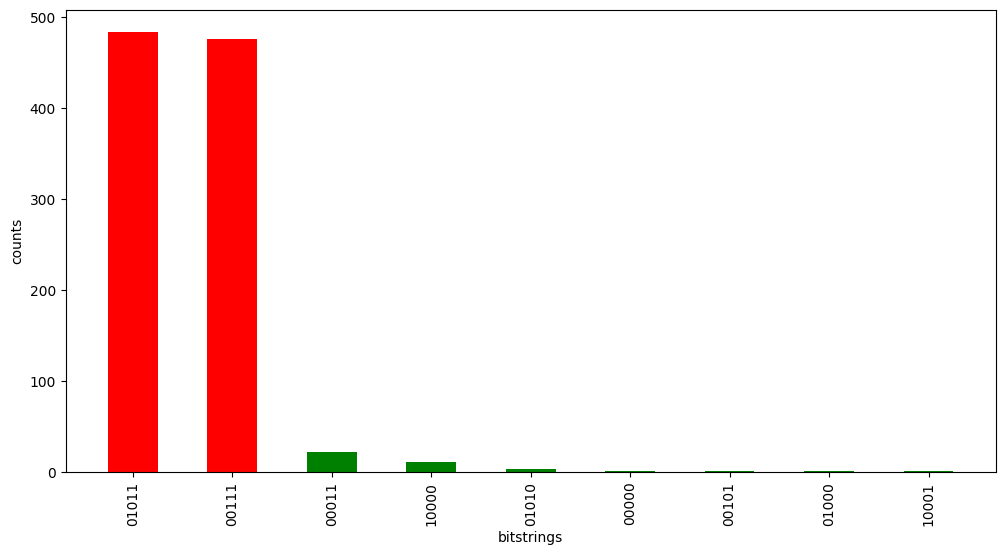

In [20]:
plot_distribution(count_dict)

See how fast and performant this method is! In only a few micro-seconds, we find an excellent solution.

### How does the time evolution affect the quality of the results?

In [21]:
cost = []
for T in 1000 * np.linspace(1, 10, 10):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, Q) / 3)

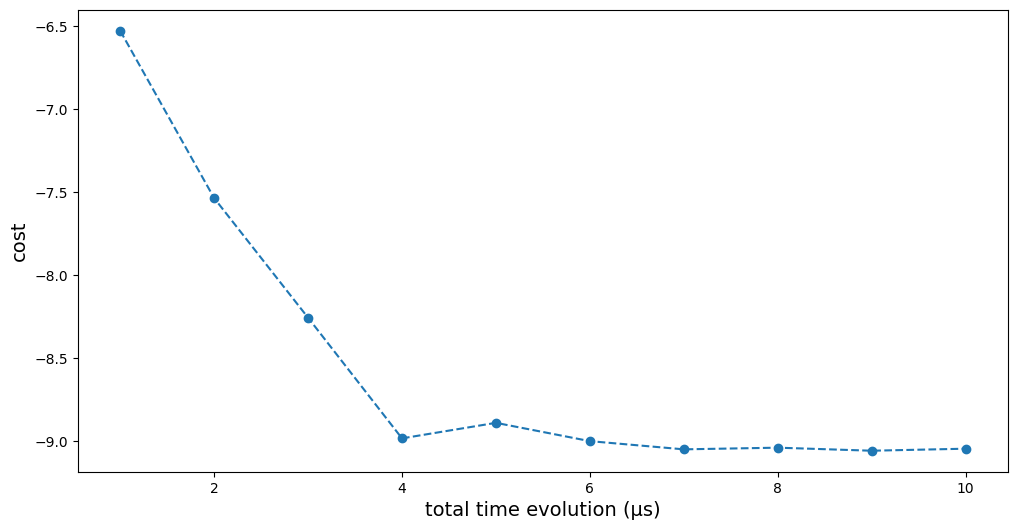

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(cost), "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()